In [0]:
from google.colab import drive
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
from sklearn.preprocessing import normalize
import gc
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D 
from keras.models import Model
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from keras.layers import Dropout
from keras import backend as K
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

In [0]:
drive.mount('/content/drive')
root_path = 'drive/My Drive/Colab Notebooks/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [0]:
#load the training data of one single angle of the exams (axial | coronal | sagittal) by giving the angle name
def trainingSet(file_name):
    training_set = []
    for np_name in sorted(glob.glob('MRNet-v1.0/train/'+file_name+'/*.npy')):
        training_set.append(np.load(np_name))
    return training_set    

In [0]:
#load the labels of one knee tear(abnormal | acl | meniscus) by the giving the file name that contains the labels
def load_labels(train_file_name):
    training_labels = np.loadtxt(train_file_name, delimiter=',')[:,1]
    return training_labels

In [0]:
#as each exam (stack) contains S slices and most of the pretrained CNN models accept the image with channel = 3
#extract the middle 3 slices as most of the time they deside if the patiant has a certain tear or not
def extract_3(dataset, data_size):
    for i in range(len(dataset)):
        dataset[i] = list(dataset[i])
        middel_idx = int(len(dataset[i]) / 2)
        dataset[i] = dataset[i][middel_idx - 1 : middel_idx + 2]
        dataset[i] = np.array(dataset[i])
    dataset = np.array(dataset)
    dataset = dataset.reshape(data_size, 256, 256 ,3)
    return dataset

In [0]:
#load the training data for each angle of the knee
training_set_axial= trainingSet('axial')
training_set_coronal=trainingSet('coronal')
training_set_sagittal=trainingSet('sagittal')

In [0]:
#extract the middel 3 slices from each stack
training_set_axial = extract_3(training_set_axial, 1130)
training_set_coronal =extract_3(training_set_coronal, 1130)
training_set_sagittal =extract_3(training_set_sagittal, 1130)

In [0]:
training_set_axial.shape

(1130, 256, 256, 3)

In [0]:
#load the labels of the trainig data for each knee tear 
training_label_abnormal = load_labels('MRNet-v1.0/train-abnormal.csv')
training_label_acl = load_labels('MRNet-v1.0/train-acl.csv')
training_label_meniscus = load_labels('MRNet-v1.0/train-meniscus.csv')

In [0]:
training_label_acl.shape

(1130,)

In [0]:
#load INCEPTIONV3 pretrainned model from keras without the top layer &
#specify the shape of the input image as (256x256x3) 
mri_InceptionV3 = InceptionV3(include_top = False, input_shape = (256, 256, 3))

#remove the last one
mri_InceptionV3.layers.pop()

#get the output of the INCEPTIONV# model "feature extraction" and add Dense layers so that the model is designed
#to classify our data
mri_InceptionV3_output = mri_InceptionV3.output

mri_InceptionV3_last_layer = GlobalMaxPooling2D()(mri_InceptionV3_output)

mri_InceptionV3_last_layer = Dense(1024, activation = 'relu')(mri_InceptionV3_last_layer)

mri_InceptionV3_last_layer = Dense(128, activation = 'relu')(mri_InceptionV3_last_layer)

mri_InceptionV3_last_layer = Dense(32, activation = 'relu')(mri_InceptionV3_last_layer)

predictor = Dense(1, activation='sigmoid')(mri_InceptionV3_last_layer)

modified_mri_InceptionV3 = Model(inputs = mri_InceptionV3.input, output = predictor)

modified_mri_InceptionV3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [0]:
#freeze the added dense layers and unfreeze the rest:
for layer in modified_mri_InceptionV3.layers[15:]:
    layer.trainable = True 
    
for layer in mri_InceptionV3.layers:
    layer.trainable = False
    
modified_mri_InceptionV3.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [0]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        print ('-val_f1 : %f '%(_val_f1))
        return
metrics = Metrics()

In [0]:
def plot_history(history):
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    plt.title('Training performance')
    plt.plot(history.epoch, history.history['loss'], label='Loss')
    plt.plot(history.epoch, history.history['val_loss'], label='validation error')
    plt.plot(history.epoch, history.history['acc'], label='accuracy')
    plt.plot(history.epoch, history.history['val_acc'], label='validation accuracy')
    plt.plot(metrics.val_f1s, label='f_score')
    plt.grid(True,color='white')
    mpl.style.use('seaborn')
    plt.legend() 
          

In [0]:
#train the model with 1073 trainning data & 57 validation data
#save the model that has the max validation accuracy
#at the end plot the trainng loss & accuracy, validation loss & accuracy & F-score 
def fit_model(training_set, training_labels, model_file_name):
  
    history = modified_mri_InceptionV3.fit(x = training_set, y = training_labels, batch_size=32,
                       epochs=30, validation_split = 0.05,
                       callbacks =[
                          EarlyStopping(patience=3, monitor = 'val_loss', mode = 'min'),
                          ModelCheckpoint(model_file_name, monitor='val_acc', save_best_only=True, mode='max', period=1), metrics])
    plot_history(history)
    best_model = load_model(model_file_name)
    return best_model

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 51s 48ms/step - loss: 0.7450 - acc: 0.7409 - val_loss: 1.9503 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 2/30
1073/1073 [==============================] - 7s 6ms/step - loss: 0.5043 - acc: 0.7894 - val_loss: 1.2111 - val_acc: 0.8246
-val_f1 : 0.903846 
Epoch 3/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4911 - acc: 0.7829 - val_loss: 2.3140 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 4/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5190 - acc: 0.7866 - val_loss: 0.9788 - val_acc: 0.7193
-val_f1 : 0.833333 
Epoch 5/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.3996 - acc: 0.8257 - val_loss: 2.2516 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 6/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.3655 - acc: 0.8416 - val_loss: 1.3464 - val_acc: 0.7895
-val_f1 : 0.882353 
Epoch 7/30
1073/1073 [======

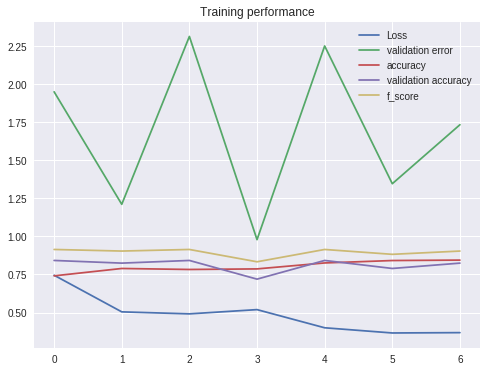

In [0]:
#train the modified INCEPTIONV3 model that will accept the axial data and classify the knee is it has an abnormal tear or not 
axial_abnormal_model = fit_model(training_set_axial, training_label_abnormal, "axial_abnormal_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.6046 - acc: 0.7819 - val_loss: 1.3688 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 2/30
  32/1073 [..............................] - ETA: 6s - loss: 0.6519 - acc: 0.7188

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1073/1073 [==============================] - 7s 7ms/step - loss: 0.4726 - acc: 0.8034 - val_loss: 0.9485 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 3/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4693 - acc: 0.8127 - val_loss: 1.5979 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 4/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4114 - acc: 0.8276 - val_loss: 1.8333 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 5/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4196 - acc: 0.8313 - val_loss: 1.8349 - val_acc: 0.8421
-val_f1 : 0.000000 


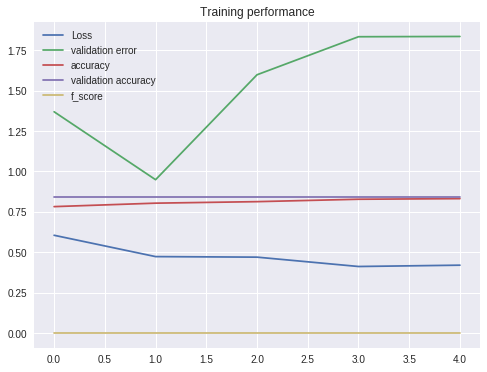

In [0]:
#train the modified INCEPTIONV3 model that will accept the axial data and classify the knee is it has an acl tear or not 
axial_acl_model = fit_model(training_set_axial, training_label_acl, "axial_acl_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.6739 - acc: 0.6505 - val_loss: 1.1731 - val_acc: 0.6140
-val_f1 : 0.000000 
Epoch 2/30
  32/1073 [..............................] - ETA: 6s - loss: 0.5649 - acc: 0.7188

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1073/1073 [==============================] - 7s 7ms/step - loss: 0.5903 - acc: 0.6934 - val_loss: 1.2215 - val_acc: 0.6842
-val_f1 : 0.400000 
Epoch 3/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5974 - acc: 0.6710 - val_loss: 1.3562 - val_acc: 0.6316
-val_f1 : 0.086957 
Epoch 4/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5609 - acc: 0.7092 - val_loss: 1.1594 - val_acc: 0.6667
-val_f1 : 0.512821 
Epoch 5/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5627 - acc: 0.7120 - val_loss: 2.7350 - val_acc: 0.6140
-val_f1 : 0.000000 
Epoch 6/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5753 - acc: 0.6999 - val_loss: 1.7573 - val_acc: 0.6491
-val_f1 : 0.285714 
Epoch 7/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5655 - acc: 0.7083 - val_loss: 1.1494 - val_acc: 0.5789
-val_f1 : 0.538462 
Epoch 8/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5393 - ac

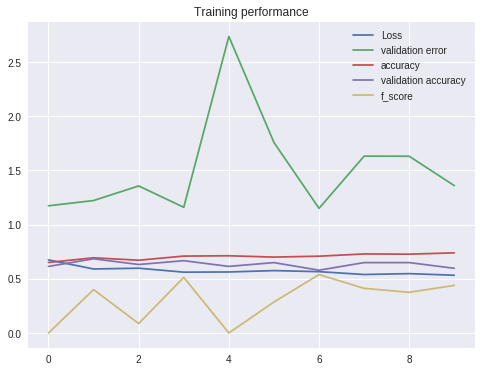

In [0]:
#train the modified INCEPTIONV3 model that will accept the axial data and classify the knee is it has a meniscus tear or not 
axial_meniscus_model = fit_model(training_set_axial, training_label_meniscus, "axial_meniscus_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5165 - acc: 0.7791 - val_loss: 1.2942 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 2/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4605 - acc: 0.8089 - val_loss: 1.4683 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 3/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4135 - acc: 0.8127 - val_loss: 0.9535 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 4/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.3946 - acc: 0.8034 - val_loss: 1.5497 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 5/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.3907 - acc: 0.8062 - val_loss: 1.7496 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 6/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.3551 - acc: 0.8248 - val_loss: 2.0481 - val_acc: 0.8421
-val_f1 : 0.914286 


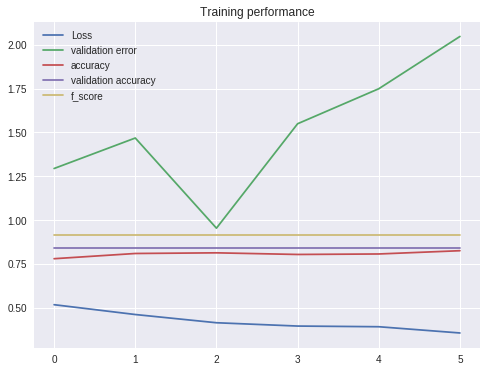

In [0]:
#train the modified INCEPTIONV3 model that will accept the coronal data and classify the knee is it has an abnormal tear or not 
coronal_abnormal_model = fit_model(training_set_coronal, training_label_abnormal, "coronal_abnormal_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5664 - acc: 0.7875 - val_loss: 1.1491 - val_acc: 0.8421


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


-val_f1 : 0.000000 
Epoch 2/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5084 - acc: 0.8145 - val_loss: 1.6462 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 3/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4874 - acc: 0.8145 - val_loss: 1.6189 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 4/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4974 - acc: 0.8145 - val_loss: 0.9538 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 5/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4903 - acc: 0.8145 - val_loss: 1.0923 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 6/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4881 - acc: 0.8145 - val_loss: 1.3405 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 7/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4867 - acc: 0.8145 - val_loss: 1.3782 - val_acc: 0.8421
-val_f1 : 0.000000 


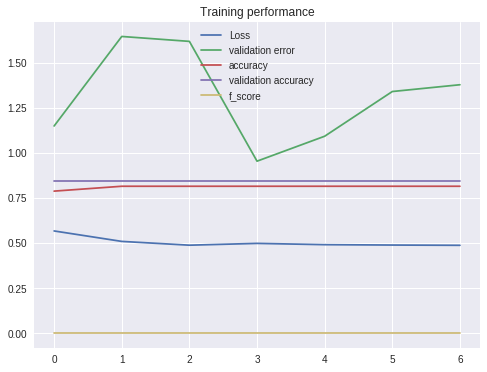

In [0]:
#train the modified INCEPTIONV3 model that will accept the coronal data and classify the knee is it has an acl tear or not 
coronal_acl_model = fit_model(training_set_coronal, training_label_acl, "coronal_acl_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.6481 - acc: 0.6505 - val_loss: 1.6396 - val_acc: 0.6140
-val_f1 : 0.000000 
Epoch 2/30
  32/1073 [..............................] - ETA: 6s - loss: 0.5691 - acc: 0.7500

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1073/1073 [==============================] - 7s 7ms/step - loss: 0.6151 - acc: 0.6598 - val_loss: 2.2550 - val_acc: 0.6140
-val_f1 : 0.000000 
Epoch 3/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.6147 - acc: 0.6542 - val_loss: 2.4030 - val_acc: 0.6140
-val_f1 : 0.000000 
Epoch 4/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5974 - acc: 0.6664 - val_loss: 3.2045 - val_acc: 0.6140
-val_f1 : 0.000000 


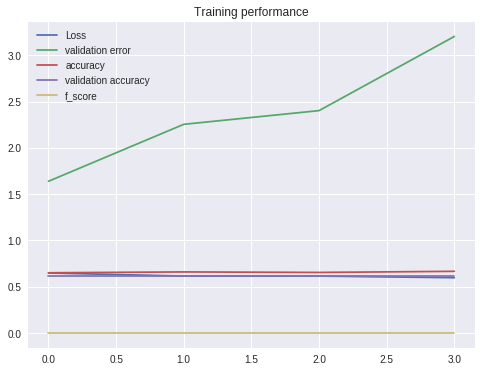

In [0]:
#train the modified INCEPTIONV3 model that will accept the coronal data and classify the knee is it has a meniscus tear or not 
coronal_meniscus_model = fit_model(training_set_coronal, training_label_meniscus, "coronal_meniscus_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5570 - acc: 0.7465 - val_loss: 1.0596 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 2/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4722 - acc: 0.8062 - val_loss: 0.6113 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 3/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4481 - acc: 0.8108 - val_loss: 0.9096 - val_acc: 0.8421
-val_f1 : 0.914286 
Epoch 4/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.3985 - acc: 0.8276 - val_loss: 0.9255 - val_acc: 0.8246
-val_f1 : 0.901961 
Epoch 5/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.3808 - acc: 0.8378 - val_loss: 0.9157 - val_acc: 0.5263
-val_f1 : 0.649351 


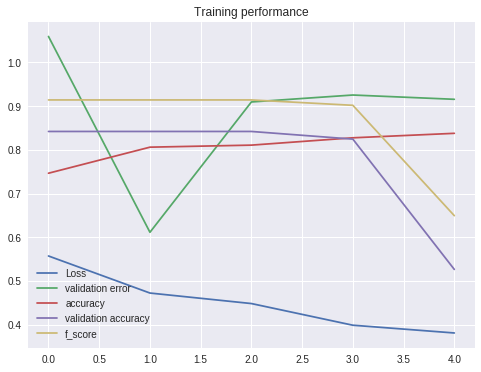

In [0]:
#train the modified INCEPTIONV3 model that will accept the sagittal data and classify the knee is it has an abnormal tear or not 
sagittal_abnormal_model = fit_model(training_set_sagittal, training_label_abnormal, "sagittal_abormal_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5274 - acc: 0.7931 - val_loss: 1.0896 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 2/30
  32/1073 [..............................] - ETA: 6s - loss: 0.4490 - acc: 0.8438

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1073/1073 [==============================] - 7s 7ms/step - loss: 0.4937 - acc: 0.8145 - val_loss: 1.6744 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 3/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4861 - acc: 0.8145 - val_loss: 1.3125 - val_acc: 0.8421
-val_f1 : 0.000000 
Epoch 4/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.4887 - acc: 0.8145 - val_loss: 1.6482 - val_acc: 0.8421
-val_f1 : 0.000000 


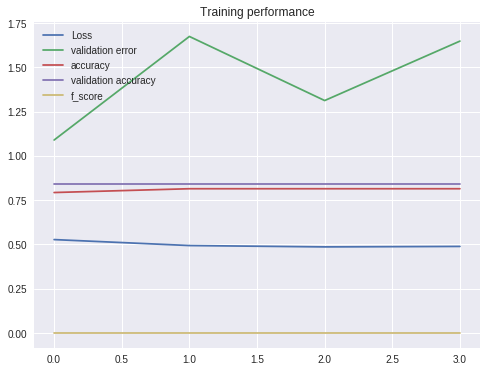

In [0]:
#train the modified INCEPTIONV3 model that will accept the sagittal data and classify the knee is it has an acl tear or not 
sagittal_acl_model = fit_model(training_set_sagittal, training_label_acl, "sagittal_acl_model")

Train on 1073 samples, validate on 57 samples
Epoch 1/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.6548 - acc: 0.6570 - val_loss: 1.3852 - val_acc: 0.6140


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


-val_f1 : 0.000000 
Epoch 2/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.6220 - acc: 0.6561 - val_loss: 0.7793 - val_acc: 0.5614
-val_f1 : 0.489796 
Epoch 3/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.6019 - acc: 0.6570 - val_loss: 1.9022 - val_acc: 0.5965
-val_f1 : 0.000000 
Epoch 4/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5808 - acc: 0.6841 - val_loss: 1.2882 - val_acc: 0.5789
-val_f1 : 0.294118 
Epoch 5/30
1073/1073 [==============================] - 7s 7ms/step - loss: 0.5752 - acc: 0.6878 - val_loss: 1.8306 - val_acc: 0.5965
-val_f1 : 0.000000 


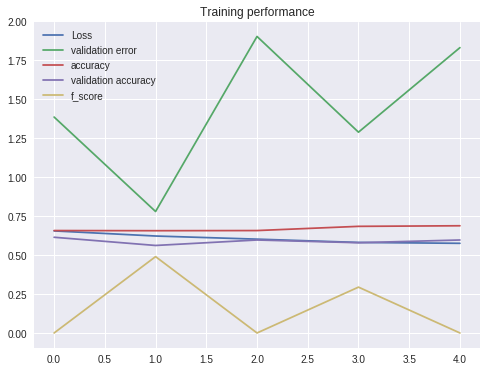

In [0]:
#train the modified INCEPTIONV3 model that will accept the sagittal data and classify the knee is it has a meniscus tear or not 
sagittal_meniscus_model = fit_model(training_set_sagittal, training_label_meniscus, "sagittal_meniscus_model")

## Evaluate the 9 models

In [0]:
#load the test data of one single angle of the exams (axial | coronal | sagittal) by giving the angle name
def testSet(file_name):
    test_set = []
    for np_name in sorted(glob.glob('MRNet-v1.0/valid/'+file_name+'/*.npy')):
        test_set.append(np.load(np_name))
    return test_set   

In [0]:
#load the test data for each angle of the knee
test_set_axial= testSet('axial')
test_set_coronal=testSet('coronal')
test_set_sagittal=testSet('sagittal')

In [0]:
#extract the middel 3 slices from each stack
test_set_axial = extract_3(test_set_axial, 120)
test_set_coronal =extract_3(test_set_coronal, 120)
test_set_sagittal =extract_3(test_set_sagittal, 120)

In [0]:
#load the labels of the test data for each knee tear 
test_label_abnormal = load_labels('MRNet-v1.0/valid-abnormal.csv')
test_label_acl = load_labels('MRNet-v1.0/valid-acl.csv')
test_label_meniscus = load_labels('MRNet-v1.0/valid-meniscus.csv')

In [0]:
axial_abnormal_model.evaluate(test_set_axial, test_label_abnormal)

120/120 [==============================] - 36s 296ms/step


[2.620534899534444, 0.7916666666666666]

In [0]:
axial_acl_model.evaluate(test_set_axial, test_label_acl) 

120/120 [==============================] - 36s 298ms/step


[4.1630372505635025, 0.55]

In [0]:
axial_meniscus_model.evaluate(test_set_axial, test_label_meniscus) 

120/120 [==============================] - 35s 294ms/step


[1.2801123062769573, 0.5500000002483527]

In [0]:
coronal_abnormal_model.evaluate(test_set_coronal, test_label_abnormal)

120/120 [==============================] - 35s 295ms/step


[1.7501238999771886, 0.7916666666666666]

In [0]:
coronal_acl_model.evaluate(test_set_coronal, test_label_acl)

120/120 [==============================] - 36s 296ms/step


[3.530718553562959, 0.55]

In [0]:
coronal_meniscus_model.evaluate(test_set_coronal, test_label_meniscus)

120/120 [==============================] - 36s 297ms/step


[1.8160638789335886, 0.5666666666666667]

In [0]:
sagittal_abnormal_model.evaluate(test_set_sagittal, test_label_abnormal)

120/120 [==============================] - 36s 302ms/step


[1.6186912363317485, 0.7916666666666666]

In [0]:
sagittal_acl_model.evaluate(test_set_sagittal, test_label_acl)

120/120 [==============================] - 37s 305ms/step


[2.8889908686280252, 0.55]

In [0]:
sagittal_meniscus_model.evaluate(test_set_sagittal, test_label_meniscus)

120/120 [==============================] - 37s 305ms/step


[1.4990095178286234, 0.5666666666666667]

In [0]:
#predict if the knee has an acl tear by using the data of the 3 knee angel (axial, coronal & sagittal)
#and the 3 models that accept one of these data and predict if the knee has an abnromal tear or not
#by doing a majority voting between the 3 models
def predict_abnormal(axial_input, coronal_input, sagittal_input, ground_truth):
    axial_abnormal_prediction = axial_abnormal_model.predict(axial_input)
    coronal_abnormal_prediction = coronal_abnormal_model.predict(coronal_input)
    sagittal_abnormal_prediction = sagittal_abnormal_model.predict(sagittal_input)
    
    #to say that the exam has the acl tear or not, each of the models will vote in this decision
    #and the final decision will be made by taking the max vote
    predict_voting = []
    for i in range (len(axial_abnormal_prediction)):
        voting_list =[0, 0] 
        
        #make the axial_acl_model vote for the final decision 
        if(axial_abnormal_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
    
        #make the coronal_acl_model vote for the final decision 
        if(coronal_abnormal_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
            
        #make the sagittal_acl_model vote for the final decision 
        if(sagittal_abnormal_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
        
        #give the exam the prediction that has the most votes
        predict_voting.append(np.argmax(voting_list))
    
  
    return accuracy_score(ground_truth, np.array(predict_voting)) * 100

In [0]:
#predict if the knee has an acl tear by using the data of the 3 knee angel (axial, coronal & sagittal)
#and the 3 models that accept one of these data and predict if the knee has an acl tear or not
#by doing a majority voting between the 3 models
def predict_acl(axial_input, coronal_input, sagittal_input, ground_truth):
    axial_acl_prediction = axial_acl_model.predict(axial_input)
    coronal_acl_prediction = coronal_acl_model.predict(coronal_input)
    sagittal_acl_prediction = sagittal_acl_model.predict(sagittal_input)
    
    #to say that the exam has the acl tear or not, each of the models will vote in this decision
    #and the final decision will be made by taking the max vote
    predict_voting = []
    for i in range (len(axial_acl_prediction)):
        voting_list =[0, 0] 
        
        #make the axial_acl_model vote for the final decision 
        if(axial_acl_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
    
        #make the coronal_acl_model vote for the final decision 
        if(coronal_acl_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
            
        #make the sagittal_acl_model vote for the final decision 
        if(sagittal_acl_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
        
        #give the exam the prediction that has the most votes
        predict_voting.append(np.argmax(voting_list))
    
  
    return accuracy_score(ground_truth, np.array(predict_voting)) * 100

In [0]:
#predict if the knee has an meniscus tear by using the data of the 3 knee angel (axial, coronal & sagittal)
#and the 3 models that accept one of these data and predict if the knee has an meniscus tear or not
#by doing a majority voting between the 3 models
def predict_meniscus(axial_input, coronal_input, sagittal_input, ground_truth):
    axial_meniscus_prediction = axial_meniscus_model.predict(axial_input)
    coronal_meniscus_prediction = coronal_meniscus_model.predict(coronal_input)
    sagittal_meniscus_prediction = sagittal_meniscus_model.predict(sagittal_input)
    
    #to say that the exam has the meniscus tear or not, each of the models will vote in this decision
    #and the final decision will be made by taking the max vote
    predict_voting = []
    for i in range (len(axial_meniscus_prediction)):
        voting_list =[0, 0] 
        
        #make the axial_meniscus_model vote for the final decision 
        if(axial_meniscus_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
    
        #make the coronal_meniscus_model vote for the final decision 
        if(coronal_meniscus_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
            
        #make the sagittal_meniscus_model vote for the final decision 
        if(sagittal_meniscus_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
        
        #give the exam the prediction that has the most votes
        predict_voting.append(np.argmax(voting_list))
    
  
    return accuracy_score(ground_truth, np.array(predict_voting)) * 100

In [0]:
#evaluate the abnormal ensemble models
print (predict_abnormal(test_set_axial, test_set_coronal, test_set_sagittal, test_label_abnormal))

79.16666666666666


In [0]:
#evaluate the acl ensemble models
print (predict_acl(test_set_axial, test_set_coronal, test_set_sagittal, test_label_acl))

55.00000000000001


In [0]:
#evaluate the meniscus ensemble models
print (predict_meniscus(test_set_axial, test_set_coronal, test_set_sagittal, test_label_meniscus))

56.666666666666664
